In [75]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline, BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.decomposition import PCA
from scipy.stats import percentileofscore

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [274]:
class ProcessDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_result = X.copy().drop(['Id','Neighborhood'], axis=1)
        ordered_levels = {
            "Alley": ["Grvl", "Pave"],
            "BsmtCond": ["Po", "Fa", "TA", "Gd"],
            "BsmtExposure": ["No", "Mn", "Av", "Gd"],
            "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            "BsmtQual": ["Fa", "TA", "Gd", "Ex"],
            "CentralAir": ["N", "Y"],
            "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
            "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
            "ExterQual": ["Fa", "TA", "Gd", "Ex"],
            "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
            "FireplaceQu": ["Po", "Fa", "TA", "Gd", "Ex"],
            'Functional': ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
            "GarageCond": ["Po", "Fa", "TA", "Gd", "Ex"],
            "GarageFinish": ["Unf", "RFn", "Fin"],
            "GarageQual": ["Po", "Fa", "TA", "Gd", "Ex"],
            "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
            "KitchenQual": ["Fa", "TA", "Gd", "Ex"],
            "LotShape": ["IR3", "IR2", "IR1", "Reg"],
            "PavedDrive": ["N", "P", "Y"],
            "PoolQC": ["Fa", "Gd", "Ex"],
            "Street": ["Grvl", "Pave"],   
            "Utilities": ["NoSeWa", "AllPub"]
        }
        
        unordered_levels = {
            'BldgType': ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'],
            'Condition1': ['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe'],
            'Condition2': ['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'],
            'Exterior1st': ['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing', 'CemntBd', 'Plywood', 
                            'AsbShng','Stucco', 'BrkComm', 'AsphShn', 'Stone', 'ImStucc', 'CBlock'],
            'Exterior2nd': ['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng', 'CmentBd', 'BrkFace', 
                            'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc', 'AsphShn', 'Stone', 'Other', 'CBlock'],
            'Foundation': ['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'],
            'GarageType': ['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'Basment', '2Types'],
            'Heating': ['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'],
            'HouseStyle': ['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin'],
            'LandContour': ['Lvl', 'Bnk', 'Low', 'HLS'],
            'LandSlope': ['Sev', 'Mod', 'Gtl'],
            'LotConfig': ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'],
            'MSZoning': ['RL', 'RM', 'C (all)', 'FV', 'RH'],
            'MasVnrType': ['BrkFace', 'None', 'Stone', 'BrkCmn'],
            'MiscFeature': ['Shed', 'Gar2', 'Othr', 'TenC'],
            'Neighborhood': ['SWISU', 'IDOTRR', 'OldTown', 'Edwards', 'BrkSide', 'NWAmes',
                             'Crawfor', 'NAmes', 'Gilbert', 'Sawyer', 'SawyerW', 'ClearCr',
                             'Blmngtn', 'Mitchel', 'NoRidge', 'CollgCr', 'Timber', 'Veenker',
                             'Somerst', 'NridgHt', 'StoneBr'],
            'RoofMatl': ['CompShg', 'WdShngl', 'Metal', 'WdShake', 'Membran', 'Tar&Grv', 'Roll', 'ClyTile'],
            'RoofStyle': ['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'],
            'SaleCondition': ['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
            'SaleType': ['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth']}
        
        X_result["HasFireplace"] = X_result["FireplaceQu"].isnull() * 1
        
        # GarageType BuiltIn, Attchd
        X_result["AttchdGarage"] = (X_result['GarageType'] == "Attchd") * 1
        
        # month_rank in order of homes sold
#        month_rank = {1: 2, 2: 3, 3: 7, 4: 9, 5: 10, 6: 12, 7: 11, 8: 8, 9: 5, 10: 6, 11: 4, 12: 1}
#        X_result['month_rank'] = X_result['MoSold'].map(lambda x: month_rank[x])
        
        for c in X_result.columns:
            #convert ordered categorical to integers
            if c in ordered_levels:
                X_result[c] = X_result[c].astype('category', categories=ordered_levels[c], ordered=True).cat.codes
            #apply levels to unordered categorical columns
            if c in unordered_levels:
                X_result[c] = X_result[c].astype('category', categories=unordered_levels[c])
        
        #convert unordered categorical to dummy columns        
        X_result = pd.get_dummies(X_result)
        return X_result
    
    def fit_transform(self, X, y=None):
        result = self.transform(X)
        return result

In [275]:
def load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')            
    y = np.log(train['SalePrice'].values)
    X = train.drop(['SalePrice'], axis=1)
    X_submission = test
    ids_submission = test['Id'].values
    return y, X, X_submission, ids_submission

In [276]:
# load data
y, X, X_submission, ids_submission = load_data()

In [277]:
parameters = {
     'gradientboostingregressor__learning_rate': [0.1],
     'gradientboostingregressor__max_depth': [4],
     'gradientboostingregressor__max_features': [0.7],
     'gradientboostingregressor__min_samples_leaf': [1],
     'gradientboostingregressor__min_samples_split': [2],
     'gradientboostingregressor__n_estimators': [250],
     'gradientboostingregressor__subsample': [0.75],
}

pipeline = make_pipeline(ProcessDataFrame(),
                         Imputer(strategy='most_frequent'),
                         GradientBoostingRegressor(random_state=1773))

#RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True)[source]

folds = KFold(10, random_state=42)

model = GridSearchCV(pipeline,
                     parameters, 
                     #n_iter=60, 
                     #random_state=1773,
                     scoring=make_scorer(rmse, greater_is_better=False), 
                     cv=folds, n_jobs=4)

In [278]:
#-0.118852946223
#0.121539801754

In [279]:
%%time
model.fit(X,y);
print 'best score:', model.best_score_
print 'best parameters:', model.best_params_

best score: -0.126122155226
best parameters: {'gradientboostingregressor__n_estimators': 250, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__subsample': 0.75, 'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__max_features': 0.7}
CPU times: user 8.82 s, sys: 251 ms, total: 9.07 s
Wall time: 36.4 s


In [280]:
best_model = model.best_estimator_

In [281]:
oof_preds = cross_val_predict(best_model, X, y)

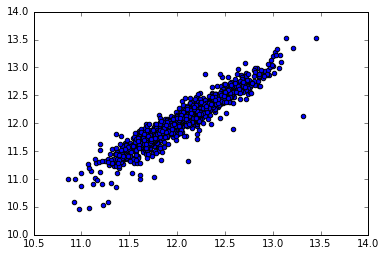

In [282]:
plt.scatter(x=oof_preds, y=y)

# Review Worst prediction

In [283]:
fold_train, fold_test = fold_indices[3]

In [284]:
best_model.fit(X.iloc[fold_train, :], y[fold_train])
fold_oof_preds = best_model.predict(X.iloc[fold_test,:])

In [285]:
worst_record = np.argmax(oof_preds - y)
print worst_record

523


In [286]:
worst_oof_pred = oof_preds[worst_record]
print worst_oof_pred

13.3161062709


In [287]:
worst_X = X.iloc[worst_record,:]

In [288]:
worst_pred = best_model.predict(pd.DataFrame([worst_X]))
print worst_pred

[ 13.40521409]


In [36]:
worst_y = y[worst_record]

In [37]:
worst_y

12.126758838810447

In [38]:
worst_pred

array([ 12.15200281])

In [54]:
np.sort(oof_preds)[::-1][0:2][1]

13.211251666217507

In [55]:
np.argwhere(oof_preds == 13.211251666217507)

array([[1169]])

In [56]:
691, 1169

(691, 1169)

In [72]:
print np.exp(y[[523, 691, 1169]])
print np.exp(oof_preds[[523, 691, 1169]])

[ 184750.  755000.  625000.]
[ 533826.64358866  589265.19464949  546479.27690458]


In [65]:
samples = X.iloc[[523, 691, 1169], :]

In [ ]:
#MSSubClass
#MSZoning
#LotFrontage

In [64]:
X.LotArea.max()

215245

In [66]:
np.log(samples.LotArea)

523     10.598982
691      9.977435
1169    10.484585
Name: LotArea, dtype: float64

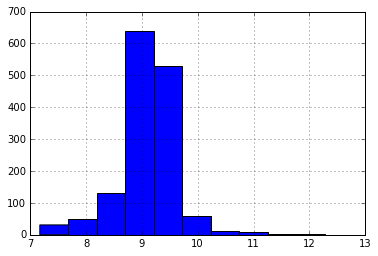

In [67]:
np.log(X.LotArea).hist()

AttributeError: 'DataFrame' object has no attribute 'Edwards'

In [131]:
X.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [130]:
X.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [160]:
#samples.drop(['Id', 'MSSubClass', 'MSZoning','LotFrontage','LotArea','Street','Alley',
#              'LotShape','LandContour','Utilities','LotConfig'], axis=1)
samples.iloc[:,:]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,0,NaN,NaN,NaN,0,10,2007,New,Partial
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal


In [187]:
print X['MoSold'].value_counts().sort_values()
print X_submission['MoSold'].value_counts().sort_values()

2      52
1      58
12     59
9      63
11     79
10     89
3     106
8     122
4     141
5     204
7     234
6     253
Name: MoSold, dtype: int64
12     45
11     63
1      64
2      81
10     84
9      95
8     111
3     126
4     138
5     190
7     212
6     250
Name: MoSold, dtype: int64


In [178]:
(X['SaleType'] + X['SaleCondition']).value_counts()

WDNormal        1160
NewPartial       122
WDAbnorml         70
CODAbnorml        24
WDFamily          19
CODNormal         19
WDAlloca          12
ConLDNormal        6
ConLwNormal        5
ConLINormal        4
WDAdjLand          4
OthAbnorml         3
ConNormal          2
WDPartial          2
CWDNormal          2
ConLDAbnorml       2
CWDAbnorml         1
ConLIAbnorml       1
ConLDPartial       1
CWDFamily          1
dtype: int64

In [169]:
#array([-0.91978747])

In [176]:
sample = base_sample.copy()
sample['SaleType'] = ['New']
y[523] - best_model.predict(sample)

array([-0.91328984])

In [125]:
def get_percentiles(column):
    print column, np.round([percentileofscore(X[column], x) for x in samples[column]],2)

get_percentiles('OpenPorchSF')

OpenPorchSF [ 99.73  66.78  78.22]


In [ ]:
In [2]: import scipy.stats as stats

In [3]: stats.percentileofscore([0,1,2,3,4,5], 0)


In [126]:
## variables that are the same
# MSSubClass 60
# MSZoning RL
# Street Pave
# Alley NaN
# LotShape IR1
# Utilities AllPub
# LandSlope Gtl
# BldgType 1Fam
# HouseStyle 2Story
# OverallQual 10
# Foundation PConc
# BsmtQual Ex
# BsmtCond TA
# BsmtExposure Gd
# BsmtFinType1 GLQ
# BsmtFinType2 Unf
# Heating GasA
# HeatingQC Ex
# CentralAir Y
# Electrical SBrkr
# Functional Typ

#YearBuilt 2007/1994/1995
#YearRemodAdd 2008/1995/1996

# numeric percentiles
# LotFrontage [ 80.96  77.26  79.69]
# LotArea [ 99.11  96.99  98.9 ]
# MasVnrArea [ 98.15  99.32  99.38]
# BsmtFinSF1 [ 99.93  98.22  97.12]
# BsmtFinSF2 [ 44.32  44.32  44.32]
# BsmtUnfSF [ 78.87  84.25  54.79]
# TotalBsmtSF [ 99.79  99.52  97.29]
# 1stFlrSF [ 99.86  99.52  95.  ]
# 2ndFlrSF [ 99.52  99.93  99.79]
# GrLivArea [ 99.93  99.79  99.73]
# BsmtFullBath [ 78.8   29.35  78.8 ]
# BsmtHalfBath [ 47.23  97.16  47.23]
# FullBath [ 98.9  98.9  98.9]
# HalfBath [ 80.89  80.89  80.89]
# BedroomAbvGr [ 55.92  90.75  90.75]
# TotRmsAbvGrd [ 98.6   96.37  96.37]
# OpenPorchSF [ 99.73  66.78  78.22]

# different in mispriced
# LandContour Bnk / Lvl
# Neighborhood Edwards/NoRidge
# Condition1 PosN, Norm
# Condition2 PosN, Norm
# Exterior1 CemntBd, HdBoard
# Exterior2 CemntBd, HdBoard
# MasVnrType Stone, BrkFace
# GarageType BuiltIn, Attchd

# all different
# LotConfig

In [132]:
! cat ../input/data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

0        3
1       10
2        5
3        3
4        1
5        6
6        8
7        4
8        9
9        2
10       3
11      11
12       5
13       8
14      10
15      11
16       7
17       6
18      12
19      10
20       4
21      12
22       5
23      12
24      10
25      11
26      10
27      10
28       1
29      10
        ..
1430    11
1431     6
1432     8
1433    10
1434    10
1435    11
1436    10
1437     4
1438     9
1439     4
1440     5
1441    10
1442     9
1443    10
1444     4
1445    10
1446     9
1447     1
1448    10
1449     8
1450     5
1451    10
1452    10
1453    11
1454     6
1455     8
1456     3
1457    10
1458     9
1459    12
Name: MoSold, dtype: int64

In [217]:
np.sqrt(np.mean((np.exp(y) - np.exp(oof_preds)) ** 2))

26491.345727225584